# Versicolor の がく片と幅の関係性を示すパラメータをベイズ推論

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
from pandas import infer_freq
from sympy import print_tree
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df_iris = sns.load_dataset('iris')  # Dataset
display(df_iris['species'].value_counts())
df_iris

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


sepal_length（がく片）と sepal_width（がくの幅）の散布図を描画

In [3]:
# 対象の品種、データの抽出
df_versicolor = df_iris.loc[df_iris['species'] == 'versicolor']  # 品種
sepal_lengths = df_versicolor.loc[:, 'sepal_length']  # がく片のデータ
sepal_widths  = df_versicolor.loc[:, 'sepal_width']   # がく幅のデータ

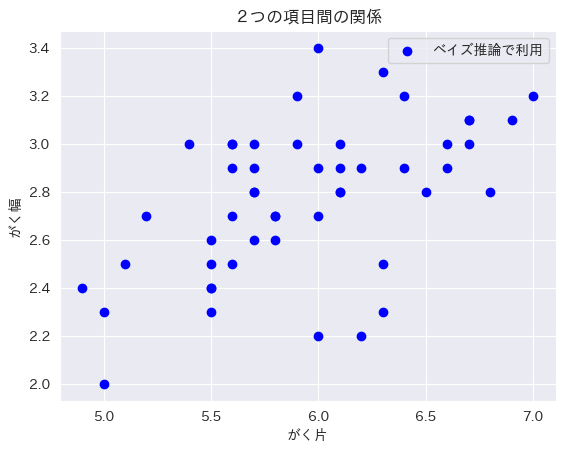

In [4]:
# 散布図の描画
plt.title('２つの項目間の関係')
plt.scatter(sepal_lengths, sepal_widths, label='ベイズ推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('がく片')
plt.ylabel('がく幅')
plt.show()

がく片とがく幅の間には仮説どおり、正の相関がありそう。

**関係性を１次関数で近似する**ことを、ベイズ推論してみる。

##### ２つの変数列の間で１次近似が可能であることを表現した数式

$Y_n = \alpha X_n + \beta + \epsilon_n$


In [5]:
# 確率モデル定義
model_linear_regression = pm.Model()  # インスタンス作成

with model_linear_regression:
    gradient = pm.Normal('gradient', mu=0, sigma=10.0)  # １次関数の傾き
    intercept = pm.Normal('intercept', mu=0, sigma=10.0)  # １次関数の切片

    mu = gradient * sepal_lengths + intercept  # 平均値 mu の計算
    standard_error = pm.HalfNormal('standard_error', sigma=1.0)  # 誤差の定義

    obs_sepal_with = pm.Normal('obs_sepal_with', mu=mu, sigma=standard_error, observed=sepal_widths)

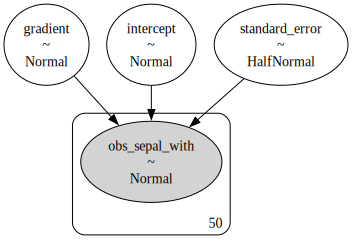

In [6]:
# 確率モデルを可視化
viz_model_Linear_regression = pm.model_to_graphviz(model_linear_regression)
viz_model_Linear_regression

`obs_sepal_with` と並んで重要な観測値の `obs_sepal_length` が、表現されていないため、改良を行う。

In [7]:
# 確率モデルの改良
model_linear_regression = pm.Model()

with model_linear_regression:
    data_sepal_length = pm.ConstantData('data_sepal_length', sepal_lengths)  # 定数データとして表現
    data_sepal_with   = pm.ConstantData('data_sepal_with',   sepal_widths)   # 定数データとして表現
    
    gradient  = pm.Normal('gradient',  mu=0.0, sigma=10.0)  # １次関数の傾き
    intercept = pm.Normal('intercept', mu=0.0, sigma=10.0)  # １次関数の切片
    
    mu = pm.Deterministic('mu', gradient * data_sepal_length + intercept)  # 平均値 mu を計算の途中経過の確率変数で表現
    standard_error = pm.HalfNormal('standard_error', sigma=1.0)  # 誤差を示す確率変数
    
    observations = pm.Normal('observations', mu=mu, sigma=standard_error, observed=data_sepal_with)

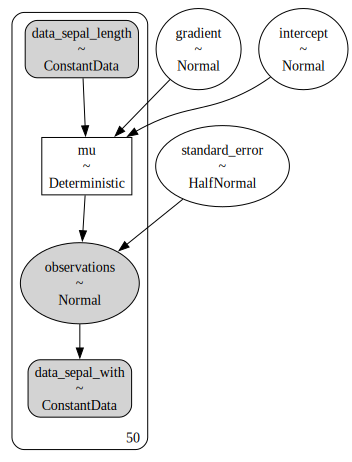

In [8]:
# 改良した確率モデルを可視化
viz_model_Linear_regression = pm.model_to_graphviz(model_linear_regression)
viz_model_Linear_regression

- ベイズ推論の対象となる確率変数は
    - `gradient`
    - `intercept`
    - `standar_error`
    の３つ（丸いアイコン）
- `data_sepal_length` と `data_sepal_width` は観測値に基づく定数データ（角が丸い四角形のアイコン）
- `mu` の計算には、
    - `data_sepal_length`
    - `gradient`
    - `intercept`
    が用いられている（四角アイコン）
- 下記の確率変数はそれぞれ要素数が 50 の配列
    - `data_sepal_length`
    - `data_sepal_width`
    - `mu`
    - `observations`
- `observations` の生成には
    - `mu`
    - `standard_error`
    がパラメータとして用いられている
- `observations` は、`data_sepal_width` を観測値として用いている。

In [9]:
# Sampling
with model_linear_regression:
    inference_linear_regression = pm.sample(chains=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gradient, intercept, standard_error]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 192 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


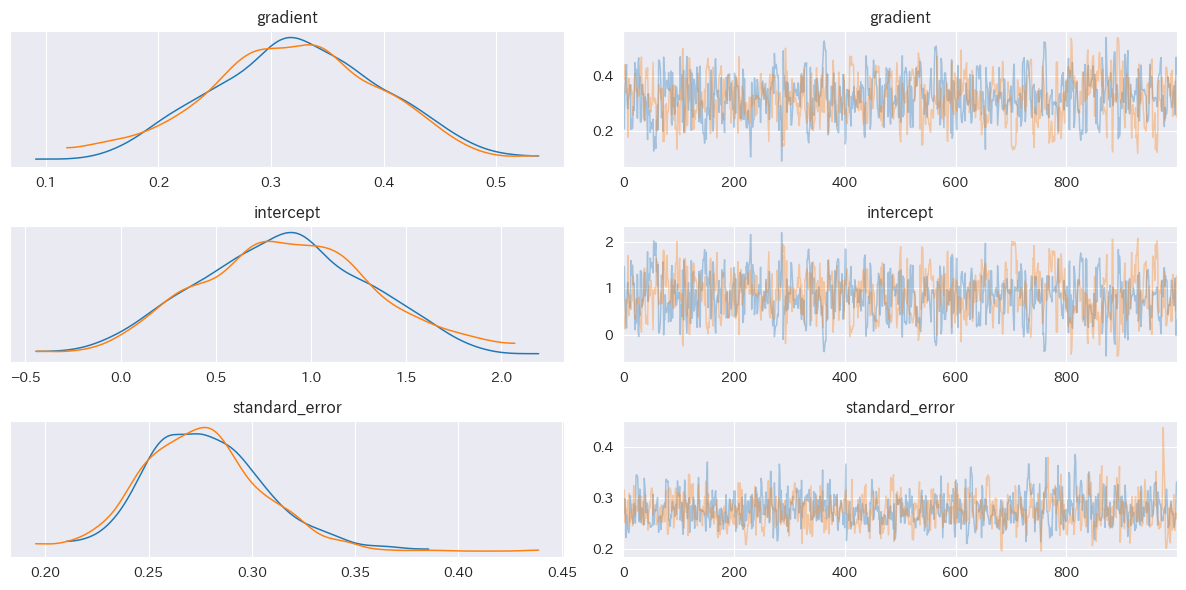

In [10]:
# 収束具体の確認
az.plot_trace(inference_linear_regression, compact=False, var_names=['gradient', 'intercept', 'standard_error'])
plt.tight_layout()
plt.show()

- 左グラフ: 各サンプル直系列の波形に違いはほぼなし。
- 右グラフ: 値の分布は均等にばらけている。

上記より、うまく収束できていそう、と判断。

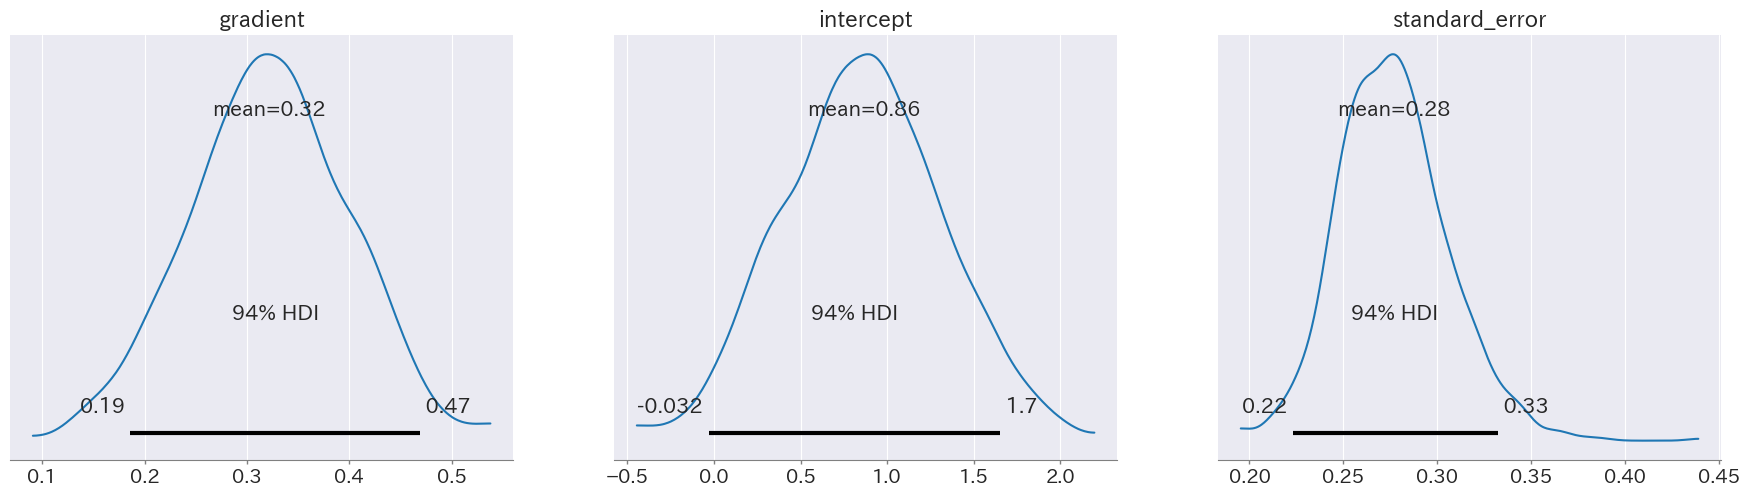

In [11]:
# 各サンプルの確率変数の分布を可視化
az.plot_posterior(inference_linear_regression, var_names=['gradient', 'intercept', 'standard_error'])
plt.show()

$$
Y_n = 0.32X_n + 0.87 + 0.28_n
$$

くらいの値になると推測される。

In [12]:
# 統計分析
az.summary(inference_linear_regression, var_names=['gradient', 'intercept', 'standard_error'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gradient,0.321,0.077,0.186,0.469,0.003,0.002,525.0,539.0,1.01
intercept,0.862,0.457,-0.032,1.652,0.020,0.014,529.0,532.0,1.01
standard_error,0.277,0.029,0.223,0.332,0.001,0.001,739.0,928.0,1.00


- mcse_mean: 概ね 0.01 以下（※切片が 0.016)
- ess_bulk:  400以上
- r_hat:  1.01以下

でほぼ問題なく推論できていると判断される。

## 散布図とサンプル値の回帰直線を可視化

In [13]:
inference_linear_regression

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [14]:
# 描画準備
values_sepal_length = np.array([sepal_lengths.min() - 0.1, sepal_lengths.max() + 0.1])
print(f'x軸の２点: {values_sepal_length, values_sepal_length.shape}')

shape_gradient = inference_linear_regression['posterior']['gradient'].values.reshape(-1, 1)  # Sampling結果から傾きの値を shape
shape_intercept = inference_linear_regression['posterior']['intercept'].values.reshape(-1, 1)  # Sampling結果から切片の値を shape
print(shape_gradient.shape, shape_intercept.shape)

# 2000 パターンそれぞれで２点の１次関数の計算
preds_petal_width = values_sepal_length * shape_gradient + shape_intercept
print(preds_petal_width.shape)

x軸の２点: (array([4.8, 7.1]), (2,))
(2000, 1) (2000, 1)
(2000, 2)


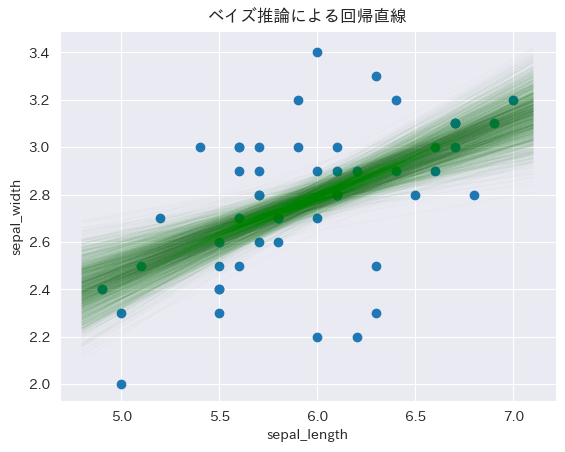

In [15]:
# 描画
for pred_petal_width in preds_petal_width:
    plt.plot(values_sepal_length, pred_petal_width, lw=1, alpha=0.01, c='g')

plt.scatter(sepal_lengths, sepal_widths)
plt.title('ベイズ推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

- 回帰直線が、幅を持った状態で示される。
- 濃淡で、回帰直線が存在する確率の高さが示される。

## 少ない観測値でベイズ推論
Sample数を３個と少ない状態にしてベイズ推論を実施。
>実務では、観測値の数の少ない、予測にとって厳しい条件で行われることが多い。

In [16]:
# 乱数で３個の Index を生成
import random
random.seed(42)

indexes = range(len(sepal_lengths))
indexes_sample = random.sample(indexes, 3)
print(f'Index値: {indexes_sample}')

# Data を３個に絞る
sepal_lengths_less = sepal_lengths.iloc[indexes_sample]
sepal_widths_less =  sepal_widths.iloc[indexes_sample]
print(f'Sepal lengths less(x)の値: {sepal_lengths_less.values}')
print(f'Sepal widths less(y)の値: {sepal_widths_less.values}')

Index値: [40, 7, 1]
Sepal lengths less(x)の値: [5.5 4.9 6.4]
Sepal widths less(y)の値: [2.6 2.4 3.2]


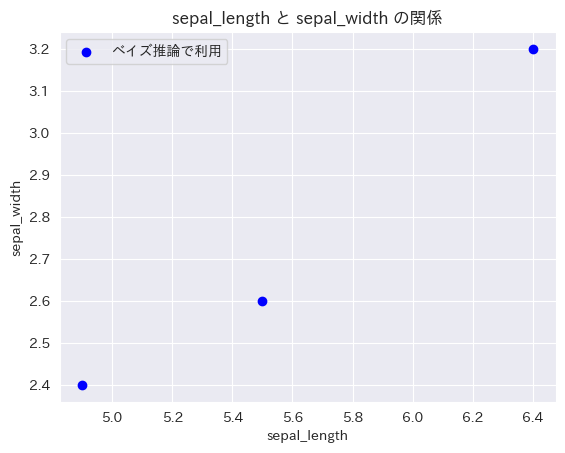

In [17]:
# 抽出した３点の散布図
plt.title('sepal_length と sepal_width の関係')
plt.scatter(sepal_lengths_less, sepal_widths_less, label='ベイズ推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

一次関数

$ Y_n = \alpha X_n + \beta + \epsilon_n $

のパラメータを推論

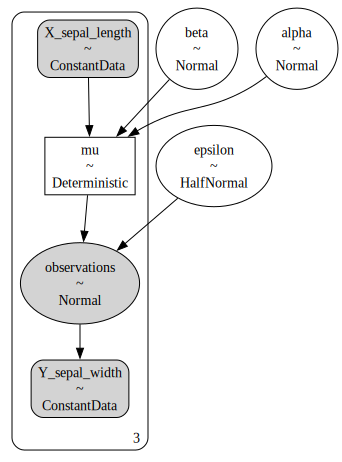

In [18]:
# 確率モデルを定義する
model_liner_regression_less = pm.Model()  # インスタンス作成

with model_liner_regression_less:
    X_sepal_length = pm.ConstantData('X_sepal_length', sepal_lengths_less)  # X(sepal_length の観測値)
    Y_sepal_width  = pm.ConstantData('Y_sepal_width', sepal_widths_less)    # Y(sepal_width  の観測値）
    
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)  # 傾き alpha
    beta  = pm.Normal('beta', mu=0.0, sigma=10.0)   # 切片 beta
    
    mu = pm.Deterministic('mu', alpha * X_sepal_length + beta)  # 平均値 mu
    
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)  # 誤差 epsilon
    
    observations = pm.Normal('observations', mu=mu, sigma=epsilon, observed=Y_sepal_width)

# 確率モデルの構造を可視化
viz_model_linear_regression_less = pm.model_to_graphviz(model_liner_regression_less)
viz_model_linear_regression_less

In [19]:
# Sampling
with model_liner_regression_less:
    inference_liner_regression_less = pm.sample(chains=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


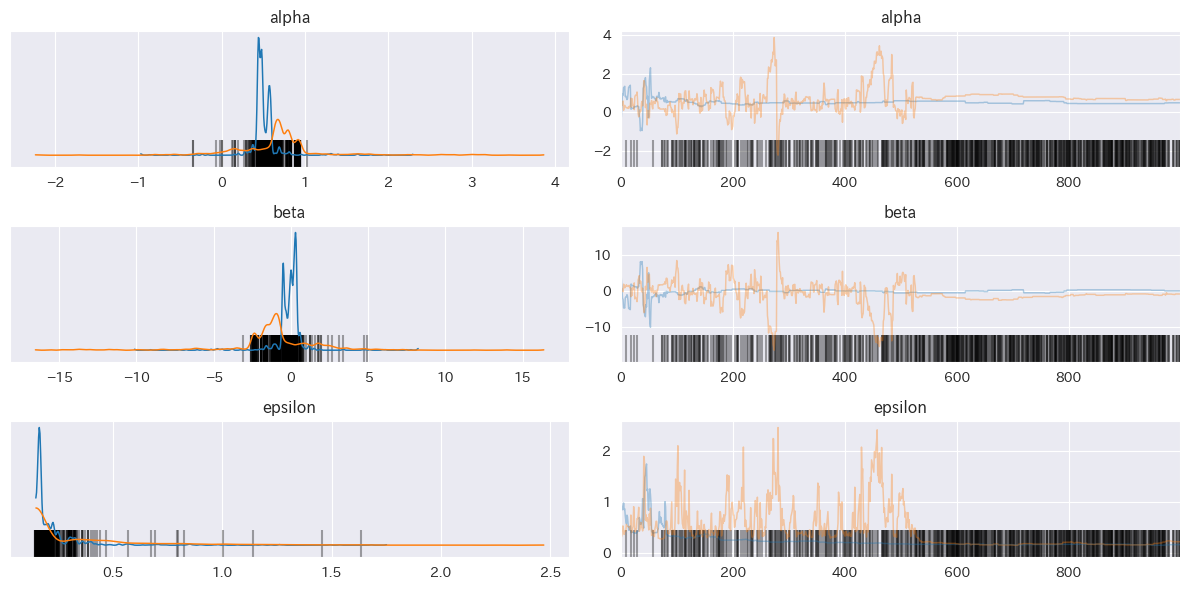

In [20]:
# 収束具合の可視化
az.plot_trace(inference_liner_regression_less, compact=False, var_names=['alpha', 'beta', 'epsilon'])
plt.tight_layout()

発散(divergences) してしまっているので `target_accept` の要調整。
> **target_accept**     
> Default値: 0.8     
> 値を 1 に近づけることにより、複雑、厳しい条件のベイズ推論の計算がうまくいく場合がでてくる。   
> 1 に近づけるほど、計算に時間がかかるようになり、計算時間と計算結果の質はトレードオフ

In [21]:
# Sampling
with model_liner_regression_less:
    inference_liner_regression_less = pm.sample(chains=2, random_seed=42, target_accept=0.995)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 337 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


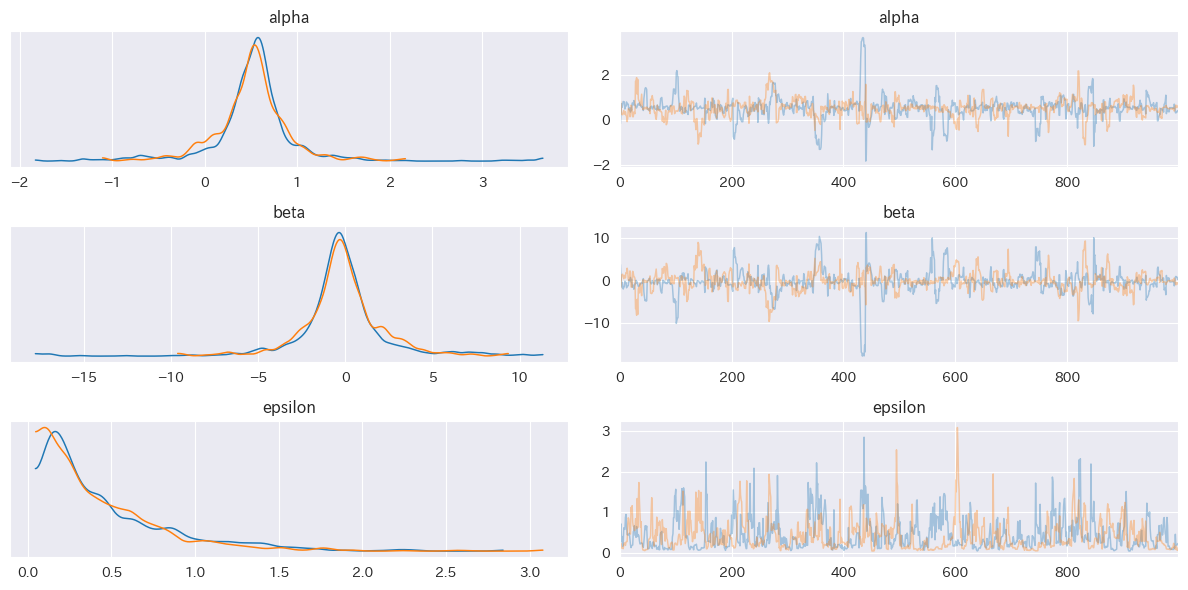

In [22]:
# 収束具体を可視化
az.plot_trace(inference_liner_regression_less, compact=False, var_names=['alpha', 'beta', 'epsilon'])
plt.tight_layout()
plt.show()

観測値が３つしかないため、少し不安定だが各サンプル直系列でほぼ同じ波形となった。

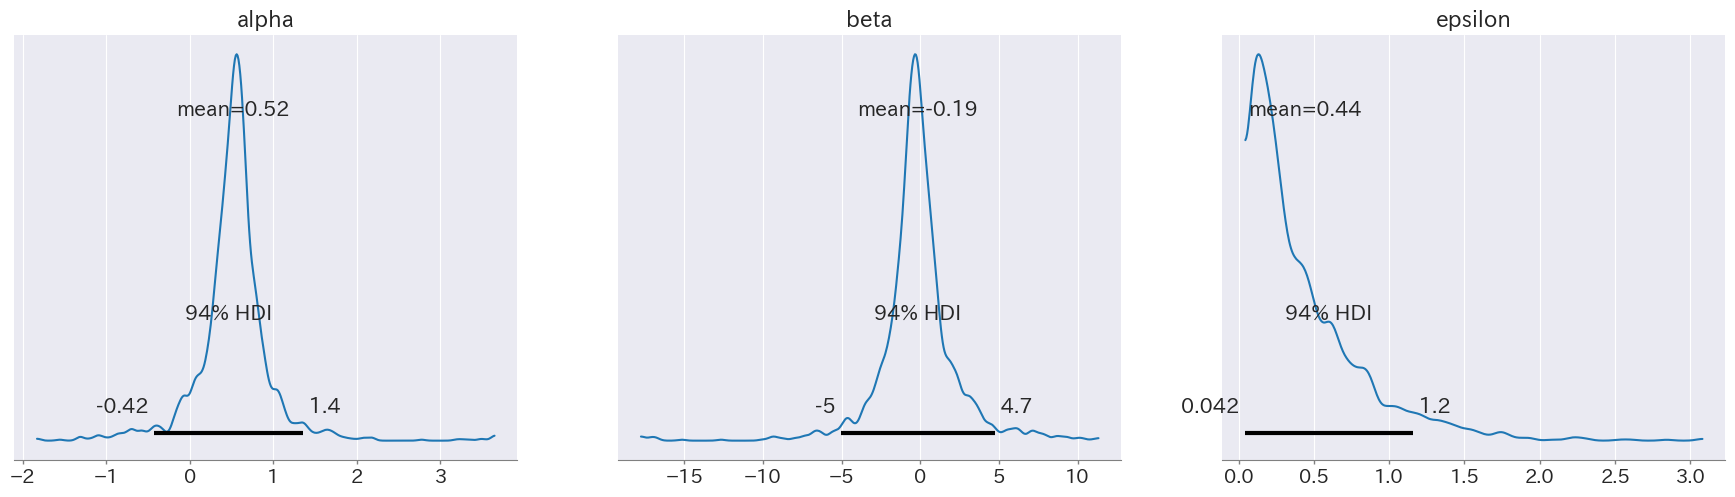

In [23]:
# 推論したパラメータの確率分布を可視化
az.plot_posterior(inference_liner_regression_less, var_names=['alpha', 'beta', 'epsilon'])
plt.show()

In [24]:
# 統計分析
summary_linear_regression_less = az.summary(inference_liner_regression_less, var_names=['alpha', 'beta', 'epsilon'])
summary_linear_regression_less  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.523,0.454,-0.425,1.355,0.027,0.021,293.0,281.0,1.02
beta,-0.193,2.577,-5.044,4.722,0.154,0.127,293.0,278.0,1.01
epsilon,0.441,0.384,0.042,1.160,0.025,0.018,177.0,323.0,1.02


- mcse_maen
- ess_bulk
- r_hat

それぞれ基準値をクリアできておらず厳しい推論結果と感じる

In [25]:
inference_liner_regression_less

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

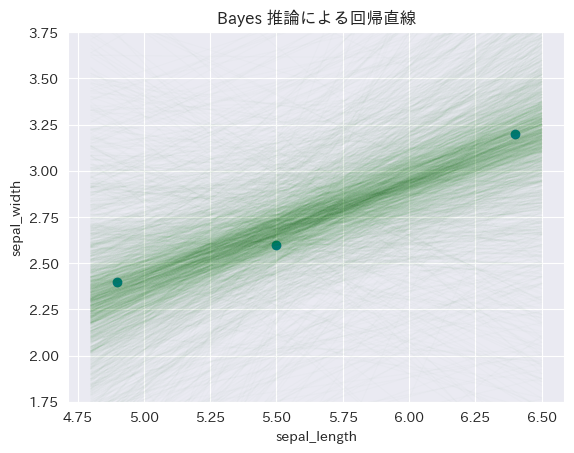

In [26]:
# 散布図と回帰直線を可視化
values_x = np.array([sepal_lengths_less.min()-0.1, sepal_lengths_less.max()+0.1])  # X の範囲を作成

alphas = inference_liner_regression_less['posterior']['alpha'].values.reshape(-1, 1)  # 傾きのデータを加工
betas  = inference_liner_regression_less['posterior']['beta'].values.reshape(-1, 1)   # 切片のデータを加工

# 2000パターンの１次関数を計算
predicts_y = values_x * alphas + betas

# 回帰直線と散布図を描画
for predict_y in predicts_y:
    plt.plot(values_x, predict_y, lw=1, alpha=0.01, c='g')

plt.scatter(sepal_lengths_less, sepal_widths_less)
plt.ylim(1.75, 3.75)
plt.title('Bayes 推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

３個しか観測値がなかったため、回帰直線の分布がかなりぼやけている。